In [17]:
from os import path
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd

import numpy as np

from datetime import datetime, timezone
from dateutil import tz
import pytz

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

## All units are kWH

In [4]:
com = pd.read_csv("alameda-county-2018-amy-aggregate-comstock.csv")
com["Timestamp (PST)"] = pd.DatetimeIndex(com['Timestamp (EST)']).tz_convert("America/Los_Angeles")
com = com.drop(columns="Timestamp (EST)")
com["month"] = [t.month for t in com["Timestamp (PST)"]]
com["day"] = [t.day for t in com["Timestamp (PST)"]]
com["hour"] = [t.hour for t in com["Timestamp (PST)"]]
com.columns

Index(['baseline.out.district_cooling.cooling.energy_consumption.kwh',
       'baseline.out.district_heating.heating.energy_consumption.kwh',
       'baseline.out.district_heating.water_systems.energy_consumption.kwh',
       'baseline.out.electricity.cooling.energy_consumption.kwh',
       'baseline.out.electricity.exterior_lighting.energy_consumption.kwh',
       'baseline.out.electricity.fans.energy_consumption.kwh',
       'baseline.out.electricity.heat_recovery.energy_consumption.kwh',
       'baseline.out.electricity.heat_rejection.energy_consumption.kwh',
       'baseline.out.electricity.heating.energy_consumption.kwh',
       'baseline.out.electricity.interior_equipment.energy_consumption.kwh',
       'baseline.out.electricity.interior_lighting.energy_consumption.kwh',
       'baseline.out.electricity.pumps.energy_consumption.kwh',
       'baseline.out.electricity.refrigeration.energy_consumption.kwh',
       'baseline.out.electricity.water_systems.energy_consumption.kwh',
    

In [6]:
com

,baseline.out.district_cooling.cooling.energy_consumption.kwh,baseline.out.district_heating.heating.energy_consumption.kwh,baseline.out.district_heating.water_systems.energy_consumption.kwh,baseline.out.electricity.cooling.energy_consumption.kwh,baseline.out.electricity.exterior_lighting.energy_consumption.kwh,baseline.out.electricity.fans.energy_consumption.kwh,baseline.out.electricity.heat_recovery.energy_consumption.kwh,baseline.out.electricity.heat_rejection.energy_consumption.kwh,baseline.out.electricity.heating.energy_consumption.kwh,baseline.out.electricity.interior_equipment.energy_consumption.kwh,...,baseline.out.natural_gas.total.energy_consumption.kwh,baseline.out.other_fuel.heating.energy_consumption.kwh,baseline.out.other_fuel.water_systems.energy_consumption.kwh,baseline.out.other_fuel.total.energy_consumption.kwh,baseline.out.site_energy.total.energy_consumption.kwh,baseline.upgrade.kwh,Timestamp (PST),month,day,hour
0,524.051043,166.135341,0.036310,2362.826707,9354.853552,31350.654272,0.0,6.871210,8988.332788,36245.597354,...,61681.967933,110.532624,127.456193,237.988818,170565.387918,0,2017-12-31 21:15:00-08:00,12,31,21
1,510.963325,176.185506,0.000000,2244.483595,9354.853552,31335.261843,0.0,5.987416,9432.322599,35465.926711,...,63439.804013,106.532140,127.041401,233.573541,171089.938775,0,2017-12-31 21:30:00-08:00,12,31,21
2,503.968650,188.314426,0.000000,2141.838257,9354.853552,31313.863821,0.0,5.598842,9863.847432,34728.395924,...,63995.409228,103.763803,123.672109,227.435913,170702.724105,0,2017-12-31 21:45:00-08:00,12,31,21
3,495.918753,199.610799,0.000000,2036.407857,9354.853552,31319.440471,0.0,4.834521,10313.737583,33950.803397,...,65167.554318,110.095557,108.872509,218.968066,170857.932348,0,2017-12-31 22:00:00-08:00,12,31,22
4,501.683474,198.007152,0.000000,1979.713212,9354.853552,31302.185492,0.0,4.320400,10633.052498,33073.741300,...,64754.237620,115.930766,106.335825,222.266591,169075.797438,0,2017-12-31 22:15:00-08:00,12,31,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,593.421302,120.406369,0.000000,2875.400966,9354.853552,31379.832852,0.0,8.449734,7521.927815,39824.940317,...,62283.763321,80.472080,169.565683,250.037763,177465.524115,0,2018-12-31 20:00:00-08:00,12,31,20
35036,583.169823,127.574761,0.000000,2772.369435,9354.853552,31368.144436,0.0,8.470626,7802.779811,39034.051388,...,60524.119857,86.455080,168.950805,255.405885,174266.803483,0,2018-12-31 20:15:00-08:00,12,31,20
35037,572.022584,134.311925,0.000000,2674.520462,9354.853552,31363.115484,0.0,8.493289,8051.794547,38390.252263,...,59156.508437,91.996830,165.203929,257.200759,171599.768624,0,2018-12-31 20:30:00-08:00,12,31,20
35038,554.772195,141.174881,0.250197,2574.292311,9354.853552,31346.138851,0.0,8.193746,8312.476166,37625.417604,...,59489.514761,97.633219,146.599641,244.232860,170514.404200,0,2018-12-31 20:45:00-08:00,12,31,20


Here, I remove all the energy readings that don't come from the power grid.

In [7]:
com_electricity = com[[col for col in com.columns if "baseline.out.electricity" in col]]
com_electricity = com_electricity.rename(columns=dict(zip(com_electricity.columns, [c[25:-23] for c in com_electricity.columns])))
com_electricity

,cooling,exterior_lighting,fans,heat_recovery,heat_rejection,heating,interior_equipment,interior_lighting,pumps,refrigeration,water_systems,total
0,2362.826707,9354.853552,31350.654272,0.0,6.871210,8988.332788,36245.597354,16127.513076,794.657400,487.360015,2236.540520,107955.206895
1,2244.483595,9354.853552,31335.261843,0.0,5.987416,9432.322599,35465.926711,15542.957855,793.730441,487.390196,2066.496622,106729.410829
2,2141.838257,9354.853552,31313.863821,0.0,5.598842,9863.847432,34728.395924,15017.714029,795.322393,487.414118,2078.745975,105787.594342
3,2036.407857,9354.853552,31319.440471,0.0,4.834521,10313.737583,33950.803397,14490.428296,796.085234,487.440602,2021.847367,104775.878880
4,1979.713212,9354.853552,31302.185492,0.0,4.320400,10633.052498,33073.741300,13940.034051,795.454790,462.516785,1853.729010,103399.601090
...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2875.400966,9354.853552,31379.832852,0.0,8.449734,7521.927815,39824.940317,19305.695547,801.734577,487.502839,2657.555492,114217.893691
35036,2772.369435,9354.853552,31368.144436,0.0,8.470626,7802.779811,39034.051388,18563.069750,800.228342,487.476919,2585.087249,112776.531508
35037,2674.520462,9354.853552,31363.115484,0.0,8.493289,8051.794547,38390.252263,17859.752236,797.831084,487.467970,2491.642403,111479.723290
35038,2574.292311,9354.853552,31346.138851,0.0,8.193746,8312.476166,37625.417604,17217.977305,796.024100,487.313945,2361.770117,110084.457696


In [8]:
means = com_electricity.mean().sort_values()[:-1] # getting rid of the total column

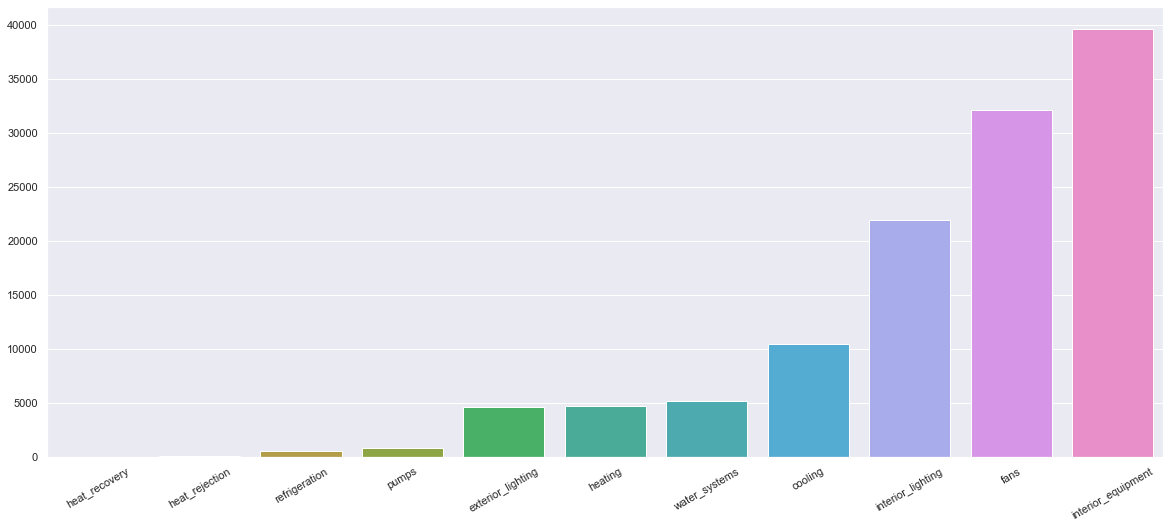

In [9]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.barplot(x=means.index, y=means)
plt.xticks(rotation=30);

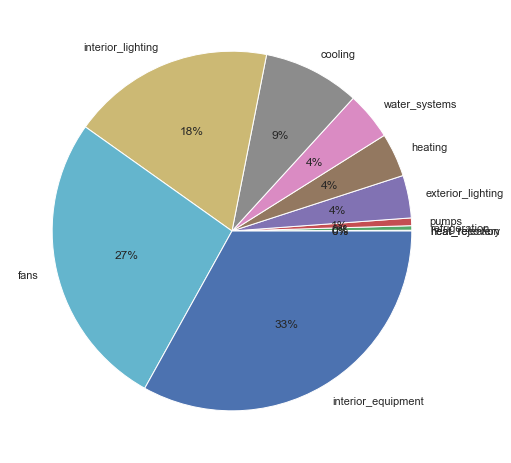

In [10]:
plt.pie(means, labels = means.index, autopct='%.0f%%');

In [11]:
df = com_electricity
df["Timestamp (PST)"] = com["Timestamp (PST)"]
df["month"] = com["month"]
df["hour"] = com["hour"]
df = df.drop(columns="total")
df

,cooling,exterior_lighting,fans,heat_recovery,heat_rejection,heating,interior_equipment,interior_lighting,pumps,refrigeration,water_systems,Timestamp (PST),month,hour
0,2362.826707,9354.853552,31350.654272,0.0,6.871210,8988.332788,36245.597354,16127.513076,794.657400,487.360015,2236.540520,2017-12-31 21:15:00-08:00,12,21
1,2244.483595,9354.853552,31335.261843,0.0,5.987416,9432.322599,35465.926711,15542.957855,793.730441,487.390196,2066.496622,2017-12-31 21:30:00-08:00,12,21
2,2141.838257,9354.853552,31313.863821,0.0,5.598842,9863.847432,34728.395924,15017.714029,795.322393,487.414118,2078.745975,2017-12-31 21:45:00-08:00,12,21
3,2036.407857,9354.853552,31319.440471,0.0,4.834521,10313.737583,33950.803397,14490.428296,796.085234,487.440602,2021.847367,2017-12-31 22:00:00-08:00,12,22
4,1979.713212,9354.853552,31302.185492,0.0,4.320400,10633.052498,33073.741300,13940.034051,795.454790,462.516785,1853.729010,2017-12-31 22:15:00-08:00,12,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2875.400966,9354.853552,31379.832852,0.0,8.449734,7521.927815,39824.940317,19305.695547,801.734577,487.502839,2657.555492,2018-12-31 20:00:00-08:00,12,20
35036,2772.369435,9354.853552,31368.144436,0.0,8.470626,7802.779811,39034.051388,18563.069750,800.228342,487.476919,2585.087249,2018-12-31 20:15:00-08:00,12,20
35037,2674.520462,9354.853552,31363.115484,0.0,8.493289,8051.794547,38390.252263,17859.752236,797.831084,487.467970,2491.642403,2018-12-31 20:30:00-08:00,12,20
35038,2574.292311,9354.853552,31346.138851,0.0,8.193746,8312.476166,37625.417604,17217.977305,796.024100,487.313945,2361.770117,2018-12-31 20:45:00-08:00,12,20


# How does energy usage breakdown by month?

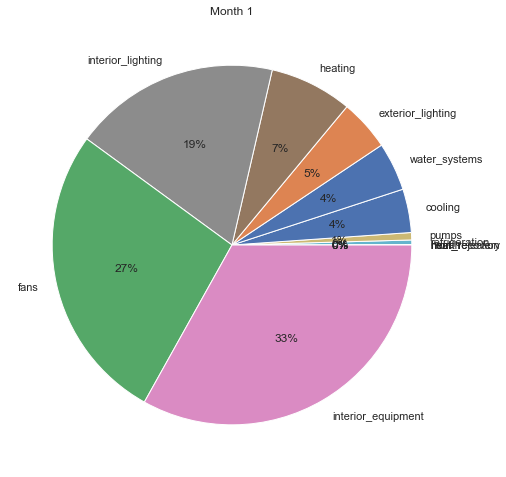

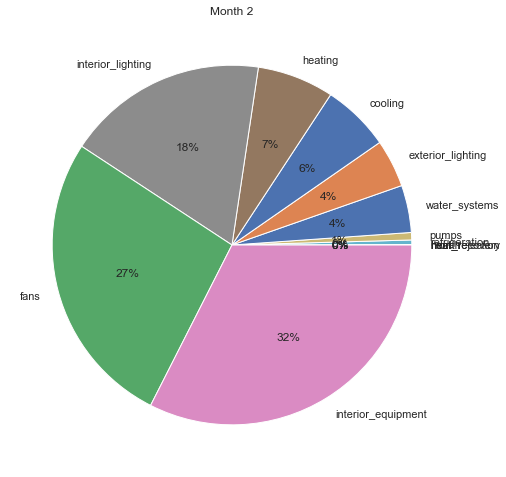

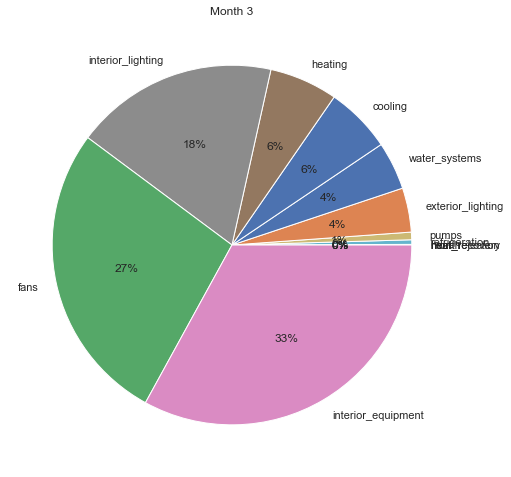

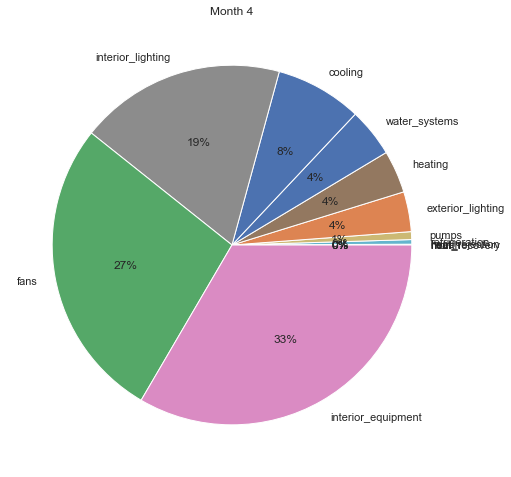

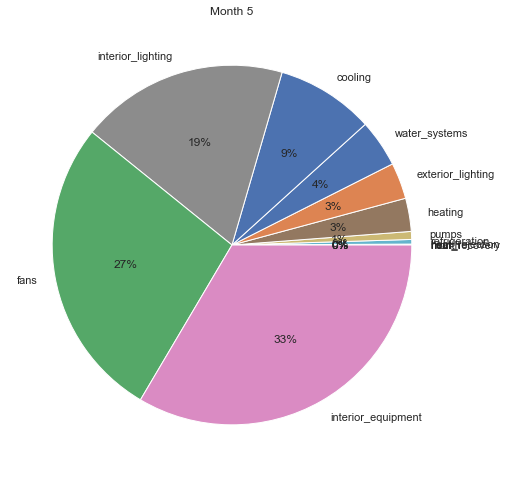

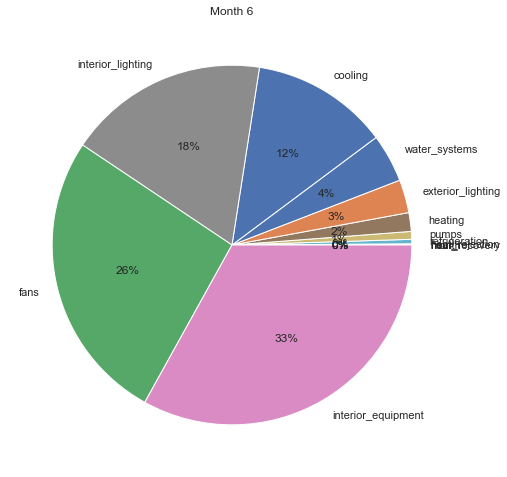

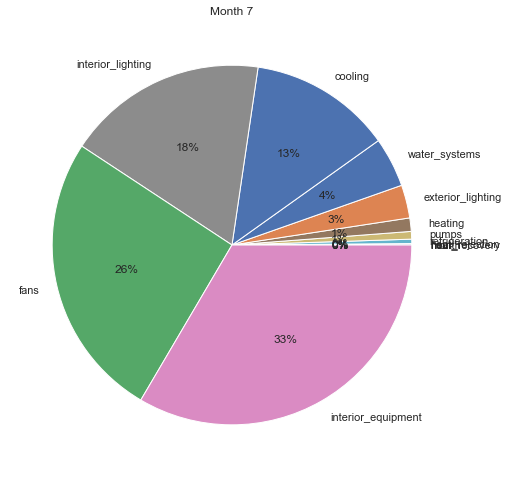

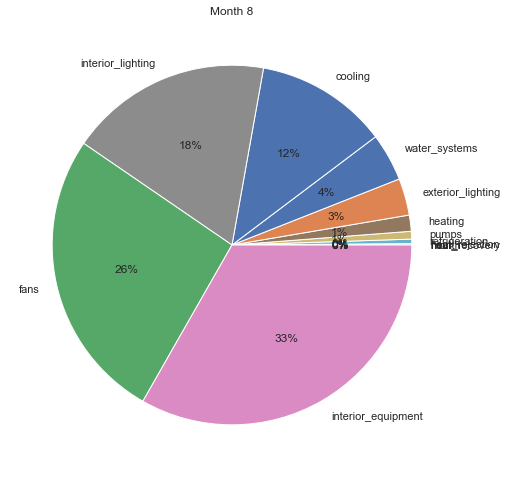

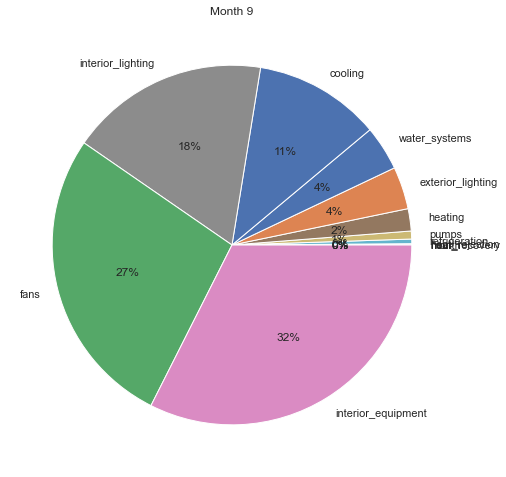

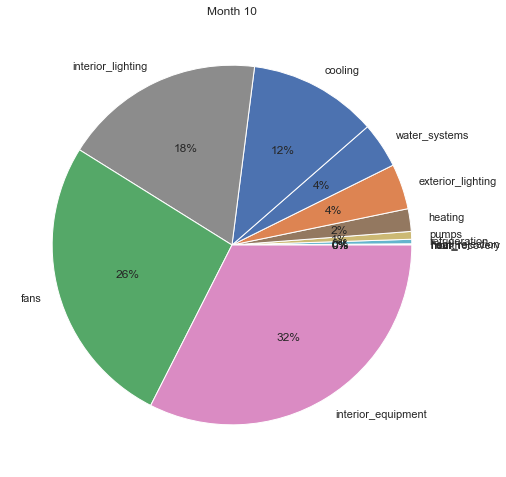

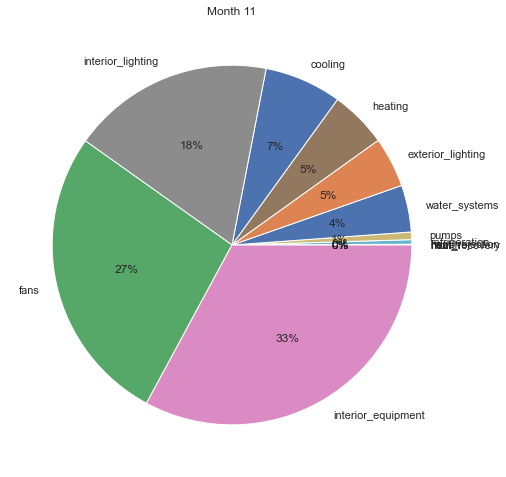

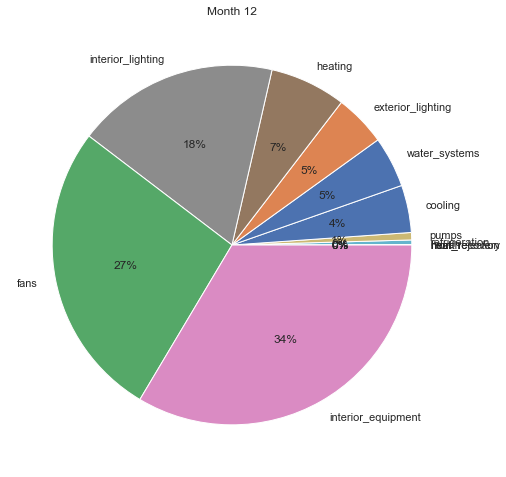

In [14]:
for i in range(1, 13):
    month_means = df[df["month"] == i].mean()
    to_plot = pd.DataFrame({"mean": month_means, "color" : sns.color_palette() + sns.color_palette()[:3]})
    to_plot = to_plot.sort_values(by="mean")
    #print(month_means)
    plt.pie(to_plot["mean"], labels = to_plot.index, colors = to_plot["color"], autopct='%.0f%%')
    plt.title("Month " + str(i))
    plt.show()

In [15]:
df = com_electricity
df["month"] = com["month"]
df["day"] = com["day"]
group_by_day = df.groupby(["month", "day"]).mean()
group_by_day["date"] = pd.date_range(start='1/1/2018', end='12/31/2018', periods=365).tolist()
group_by_day

cooling  exterior_lighting          fans  heat_recovery  \
month day                                                                
1     1    5221.865496        5588.667966  32255.735062            0.0   
      2    4021.119516        5588.667966  32264.171181            0.0   
      3    3646.859914        5588.667966  32385.747487            0.0   
      4    5197.033322        5588.667966  32241.489867            0.0   
      5    5814.184754        5588.667966  32212.329098            0.0   
...                ...                ...           ...            ...   
12    27   6188.079268        5588.667966  32208.944166            0.0   
      28   6973.489916        5588.667966  32280.176500            0.0   
      29   4691.917963        5588.667966  32174.809747            0.0   
      30   4509.151817        5588.667966  31950.514823            0.0   
      31   6159.503047        5588.667966  32304.272646            0.0   

           heat_rejection       heating  interior_equipment  \
month day                                                     
1     1         45.266513   9210.614961        44365.277776   
      2         37.397353   8967.201889        44365.277776   
      3         40.810090   9322.436000        44370.250998   
      4         58.642301   5510.406828        40388.603835   
      5         83.307510   5432.909447        44150.901618   
...                   ...           ...                 ...   
12    27        24.716452   7159.998496        40388.603835   
      28        24.438187   7501.834446        44351.861580   
      29        16.718066  11726.237030        37265.550196   
      30        25.983226   9899.597431        36952.729461   
      31        20.110806   8118.966978        44327.524798   

           interior_lighting       pumps  refrigeration  water_systems  \
month day                                                                
1     1         25963.954324  792.515704     439.117088    6035.708546   
      2         25963.954324  793.964105     482.795542    6049.534059   
      3         25964.827263  806.524167     482.997864    6050.569237   
      4         21080.599981  806.717750     483.386271    6063.210914   
      5         25666.599766  816.109701     483.491346    5772.706958   
...                      ...         ...            ...            ...   
12    27        21080.599981  804.275283     481.666196    6049.208915   
      28        25942.191783  814.874553     481.187188    6040.656258   
      29        16337.560630  759.007184     481.646986    5551.744287   
      30        16294.798725  754.196307     482.461046    5252.962754   
      31        25921.192418  807.428434     481.180690    6046.387184   

                   total  hour       date  
month day                                  
1     1    129918.723436  11.5 2018-01-01  
      2    128534.083710  11.5 2018-01-02  
      3    128659.690987  11.5 2018-01-03  
      4    117418.759035  11.5 2018-01-04  
      5    126021.208165  11.5 2018-01-05  
...                  ...   ...        ...  
12    27   119974.760558  11.5 2018-12-27  
      28   129999.378378  11.5 2018-12-28  
      29   114593.860056  11.5 2018-12-29  
      30   111711.063556  11.5 2018-12-30  
      31   129775.234969  11.5 2018-12-31  

[365 rows x 14 columns]

# How does appliance usage vary over time?

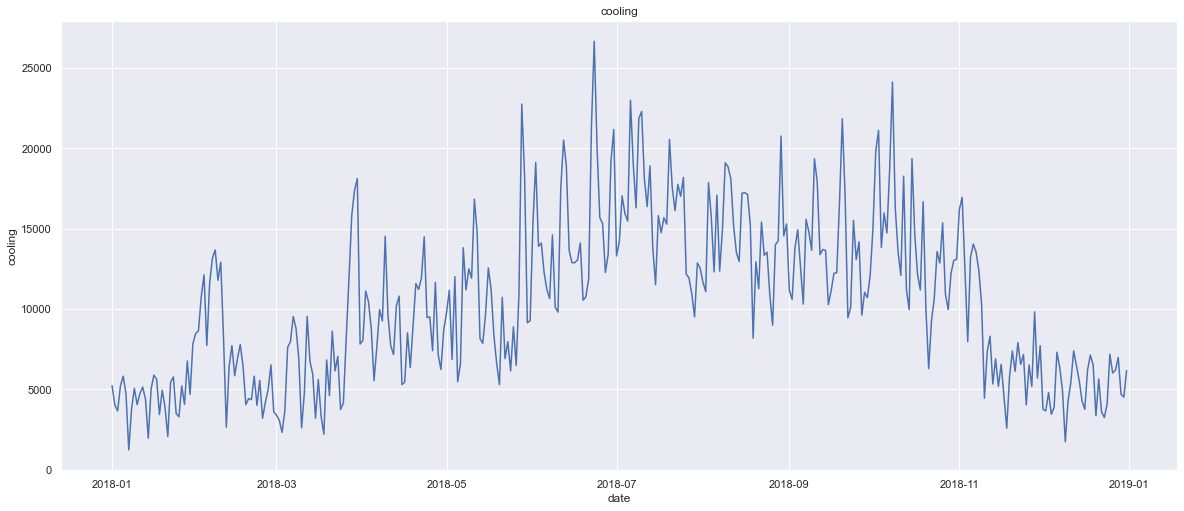

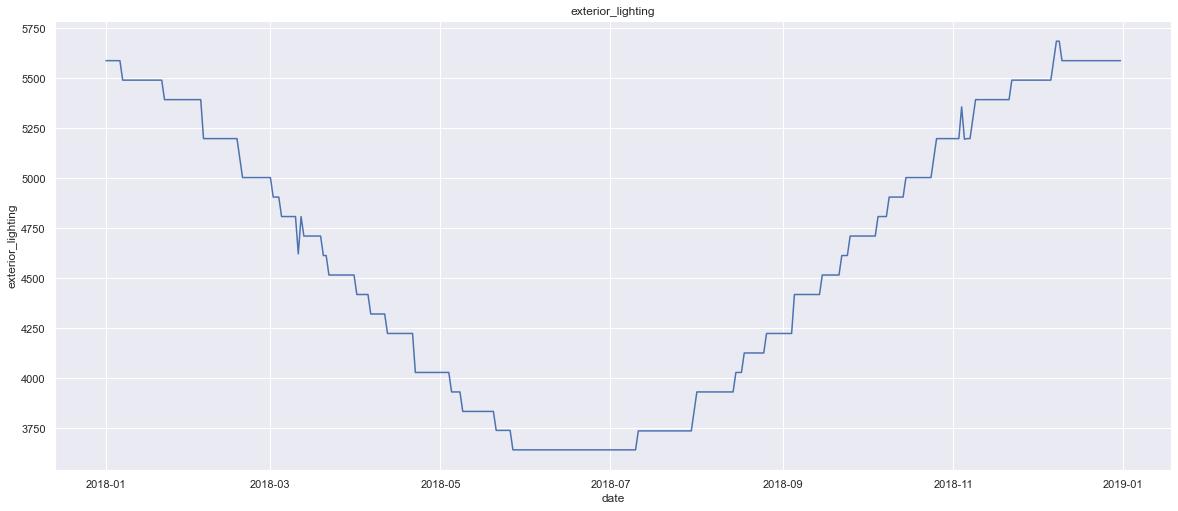

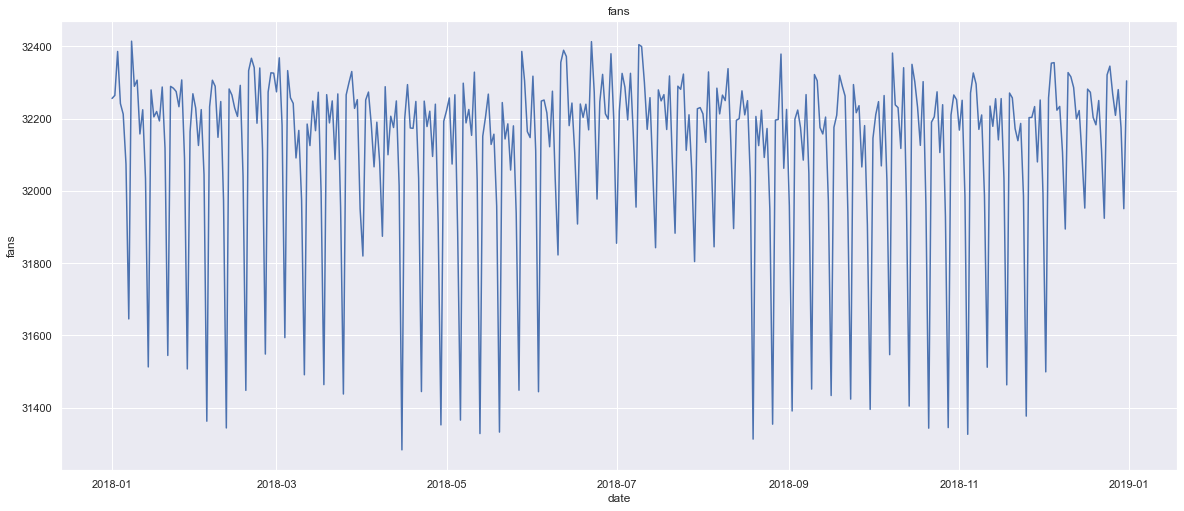

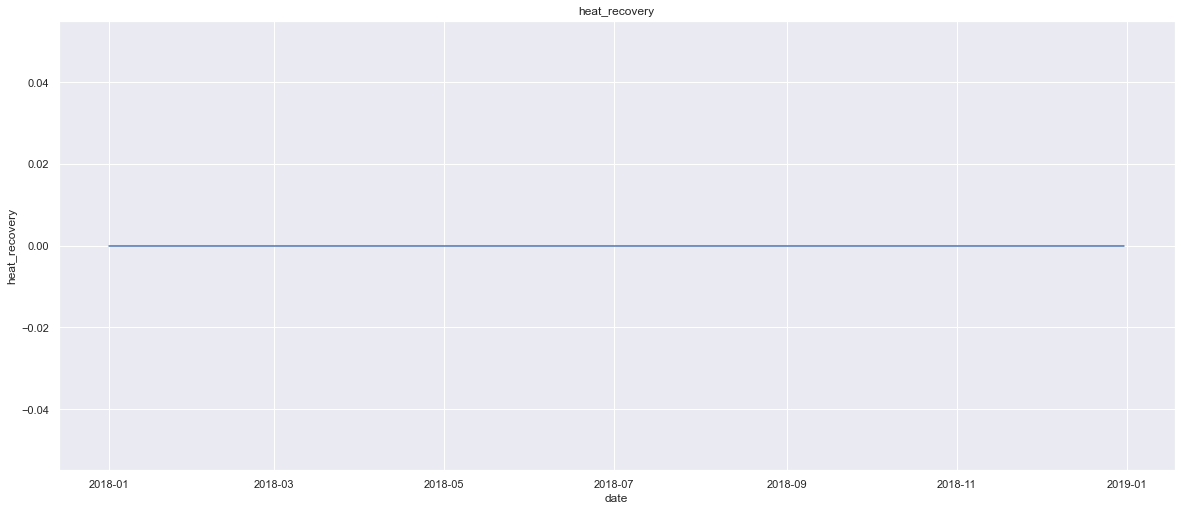

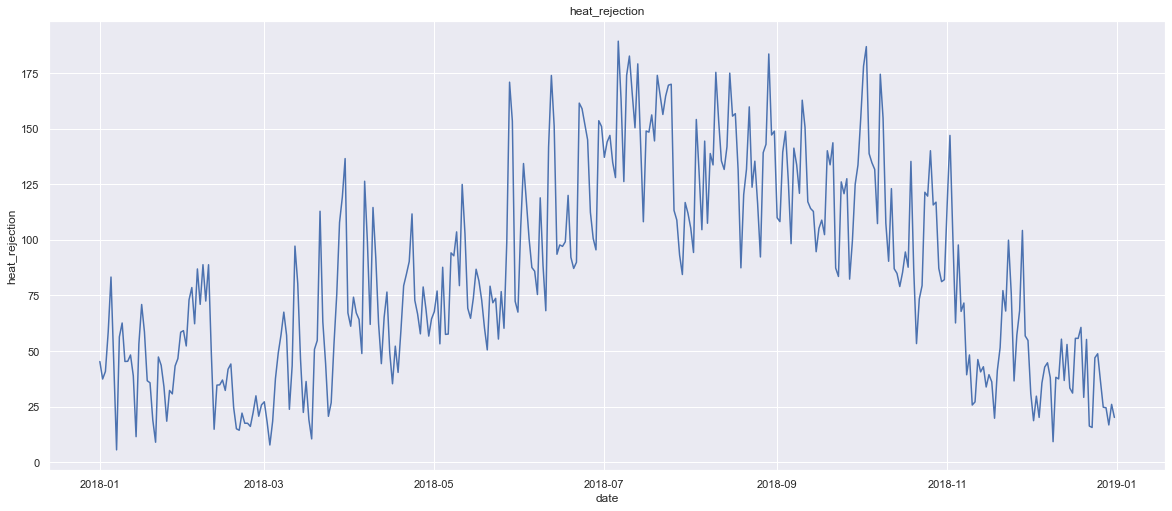

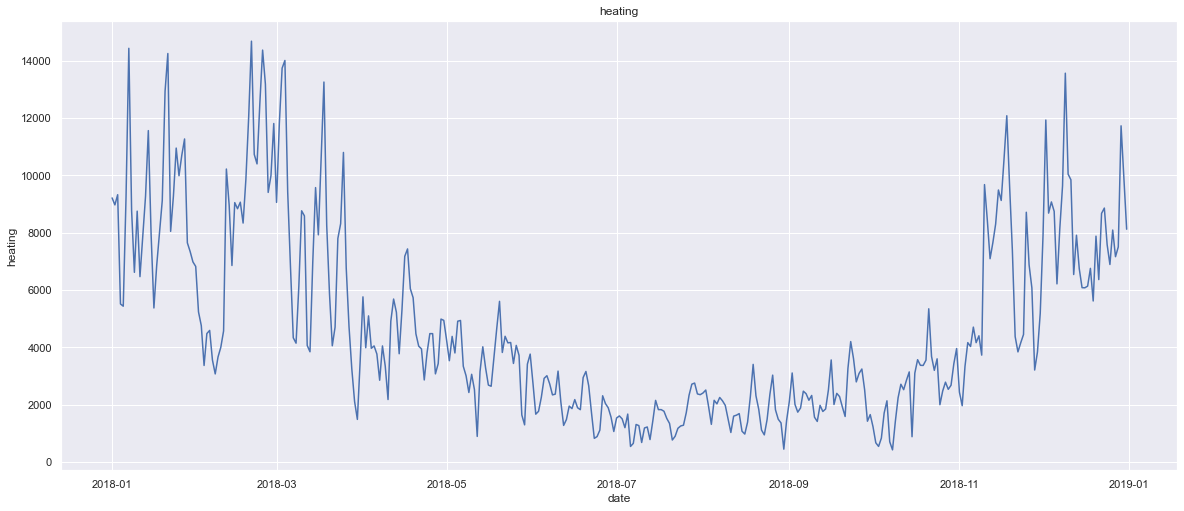

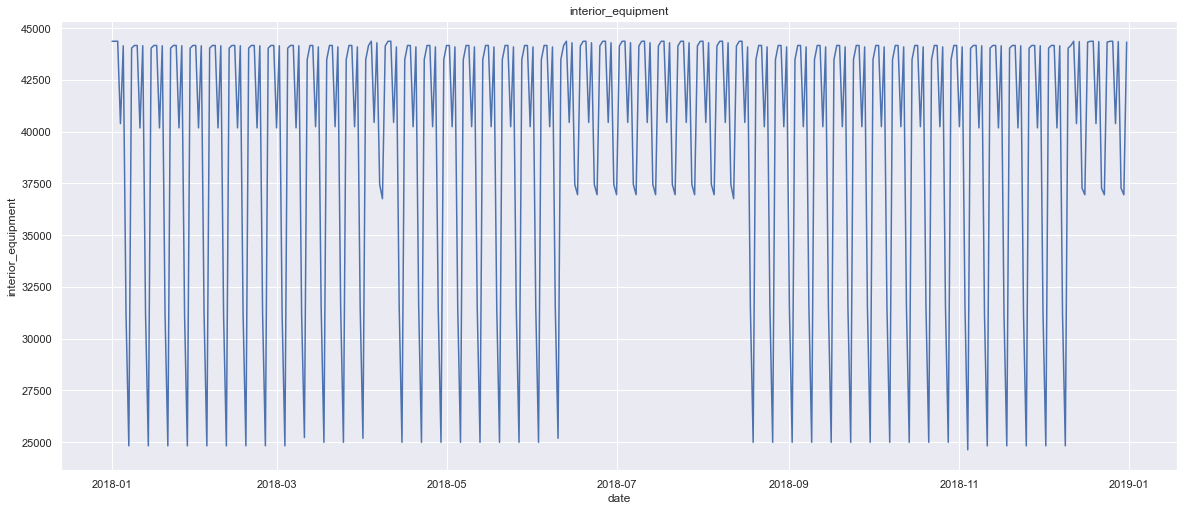

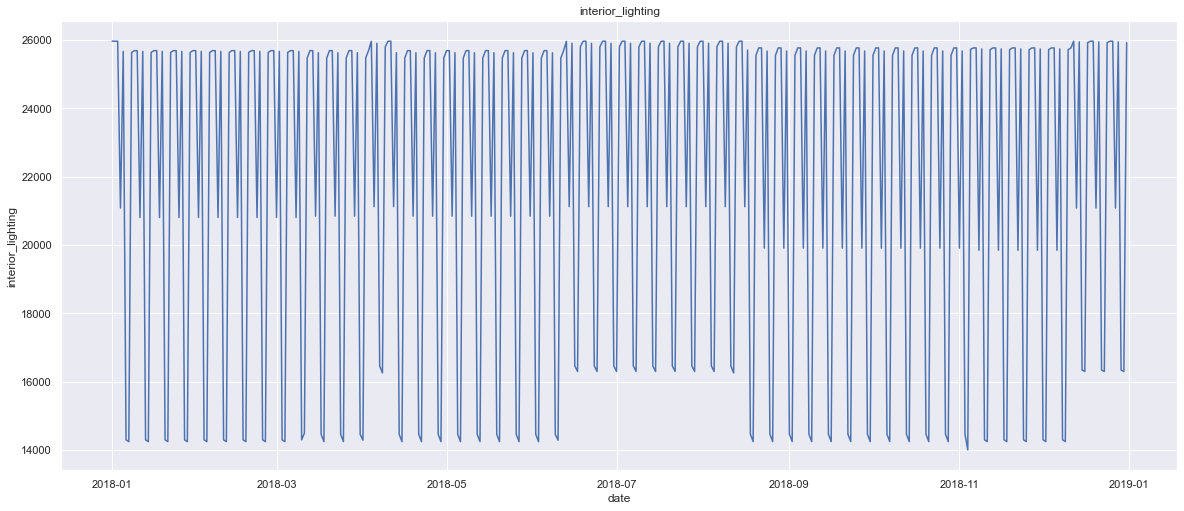

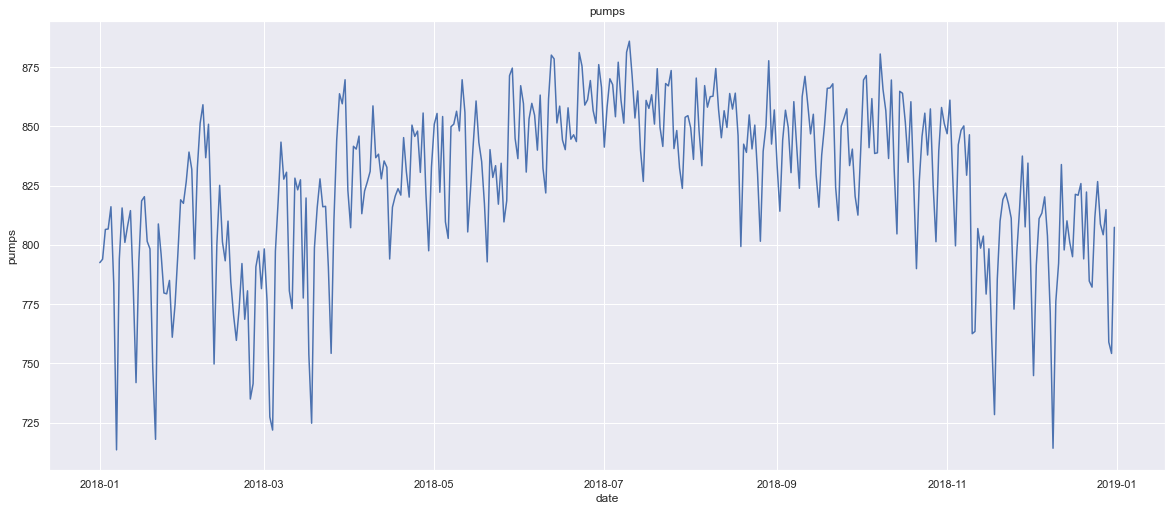

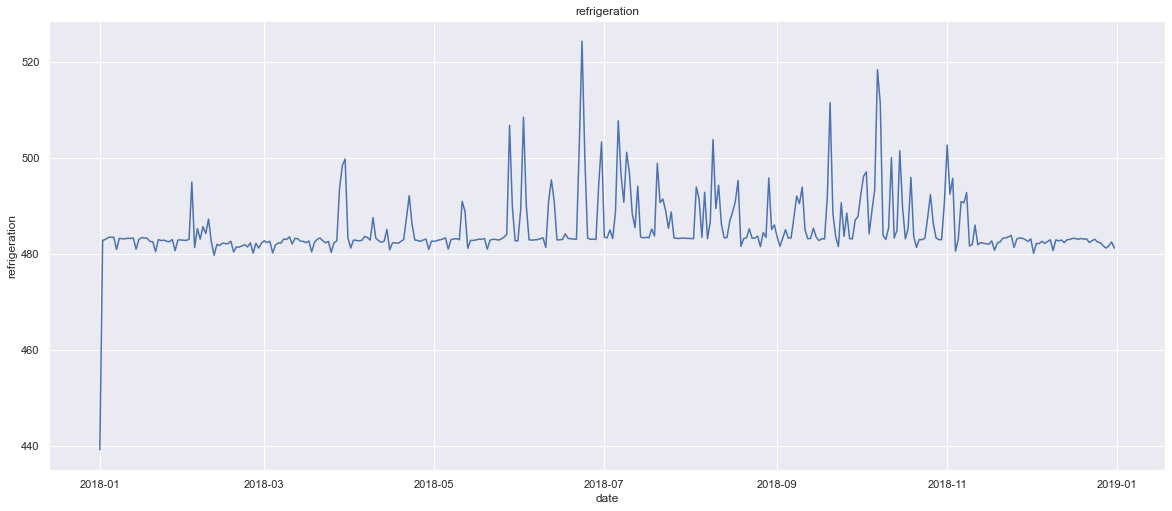

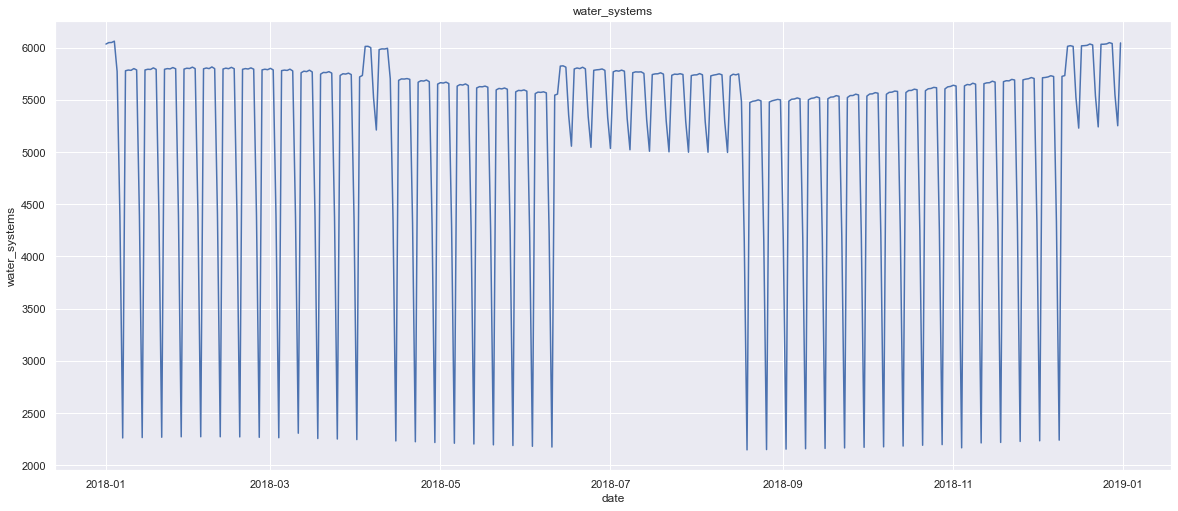

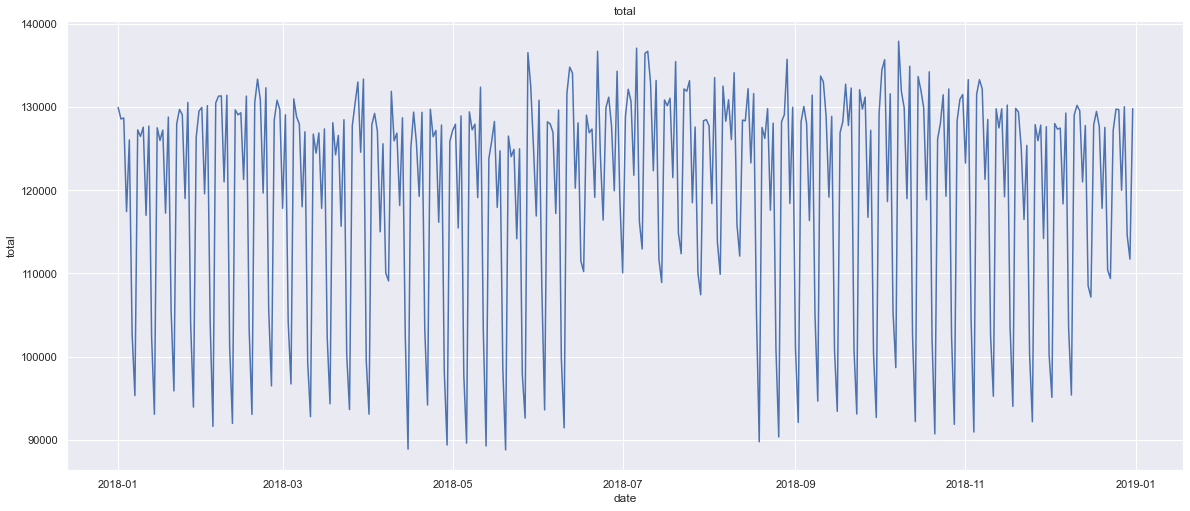

In [16]:
for i in range(len(group_by_day.columns) - 2):
    y_vals = group_by_day.iloc[:, i]
    sns.lineplot(x=group_by_day["date"], y=y_vals)
    plt.title(group_by_day.columns[i])
    plt.show();